# Log Analysis 

In [100]:
import os
import json # To read a JSON Log file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

plt.style.use('default')

## Opening the Logs

For the purpose of this project, we will be performing only 3 types of Logs (similar to what we did on Zui)

### Connections

In [101]:
def load_zeek_json(path: str) -> pd.DataFrame:
    """
    Loads Zeek JSON logs (JSONL: one JSON per line) into a DataFrame.
    Also normalizes dotted keys -> underscores for easier handling.
    """
    df = pd.read_json(path, lines=True)

    # Zeek JSON uses keys like "id.orig_h" - normalize for pandas/ML
    df = df.rename(columns=lambda c: c.replace(".", "_"))

    # Convert timestamps if present
    if "ts" in df.columns:
        df["ts_dt"] = pd.to_datetime(df["ts"], unit="s", utc=True)

    return df


In [102]:
conn_log = "./zeek-json/conn.log"
http_log = "./zeek-json/http.log"
dns_log  = "./zeek-json/dns.log"

df_conn = load_zeek_json(conn_log)
df_http = load_zeek_json(http_log)
df_dns  = load_zeek_json(dns_log)

df_conn.head()

,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,ts_dt
0,1.737575e+09,CKXrkVQel54kbwpJ,10.1.17.215,50084,10.1.17.2,389,tcp,ldap_tcp,0.003811,2229.0,...,RSTR,True,True,0,ShADadrF,6,2481,4,382,2025-01-22 19:44:56.656842947+00:00
1,1.737575e+09,Cc79ek2pyaaH0khe7,10.1.17.215,50087,23.220.102.9,80,tcp,http,0.096900,111.0,...,SF,True,False,0,ShADadfF,5,323,5,399,2025-01-22 19:45:01.364100933+00:00
2,1.737575e+09,CawJbl1h6T7zqJjII9,10.1.17.215,50086,52.156.123.84,443,tcp,ssl,0.497973,673.0,...,SF,True,False,0,ShADdaFfR,13,1205,10,3620,2025-01-22 19:45:01.022924900+00:00
3,1.737575e+09,CLK9T73gCrQaQPn3r,10.1.17.215,57386,10.1.17.2,53,udp,dns,0.000358,89.0,...,SF,True,True,0,Dd,1,117,1,188,2025-01-22 19:44:56.544982910+00:00
4,1.737575e+09,C8RXMI3IEm8zjBfeuk,10.1.17.215,56330,224.0.0.252,5355,udp,dns,0.409832,66.0,...,S0,True,False,0,D,2,122,0,0,2025-01-22 19:44:56.545732021+00:00


## Perform simple analysis

Building a timeline of connections, using datetime and event counts across the 3 types of logs (via `uid`)

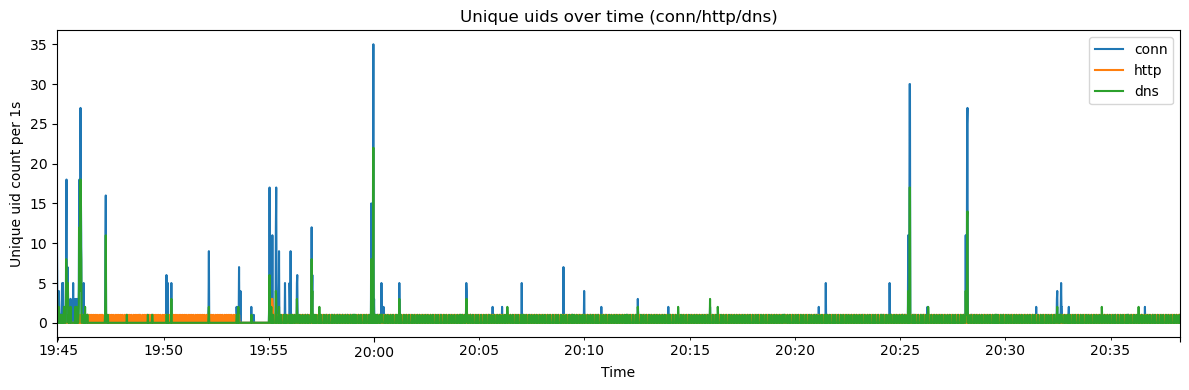

In [103]:
freq = "1s"

def uid_series(df, name, freq="1s"):
    if "ts_dt" not in df.columns:
        raise ValueError(f"{name}: missing ts_dt (did you convert ts?)")
    if "uid" not in df.columns:
        raise ValueError(f"{name}: missing uid column")

    return (
        df.set_index("ts_dt")["uid"]
          .resample(freq)
          .nunique()
          .rename(name)
    )

timeline = pd.concat(
    [
        uid_series(df_conn, "conn", freq=freq),
        uid_series(df_http, "http", freq=freq),
        uid_series(df_dns,  "dns",  freq=freq),
    ],
    axis=1
).fillna(0).astype(int)

ax = timeline.plot(figsize=(12,4))
ax.set_xlabel("Time")
ax.set_ylabel(f"Unique uid count per {freq}")
ax.set_title("Unique uids over time (conn/http/dns)")
plt.tight_layout()
plt.show()


In [105]:
http_uid = (
    df_http.groupby("uid")
           .agg(
               http_reqs=("uid", "size"),
               http_hosts=("host", lambda x: list(pd.unique(x.dropna()))[:20]),
               http_uris=("uri",  lambda x: list(pd.unique(x.dropna()))[:20]),
               http_4xx=("status_code", lambda x: int(((x >= 400) & (x < 500)).sum()) if x.notna().any() else 0),
               http_5xx=("status_code", lambda x: int((x >= 500).sum()) if x.notna().any() else 0),
           )
           .reset_index()
)

dns_uid = (
    df_dns.groupby("uid")
          .agg(
              dns_queries=("query", lambda x: list(pd.unique(x.dropna()))[:20]),
              dns_rcodes=("rcode_name", lambda x: list(pd.unique(x.dropna()))[:20]),
          )
          .reset_index()
)

flows = (
    df_conn.merge(http_uid, on="uid", how="left")
           .merge(dns_uid,  on="uid", how="left")
)

flows[["ts_dt","uid","id_orig_h","id_resp_h","id_resp_p","service","proto","http_reqs","dns_queries"]].head(10)


,ts_dt,uid,id_orig_h,id_resp_h,id_resp_p,service,proto,http_reqs,dns_queries
0,2025-01-22 19:44:56.656842947+00:00,CKXrkVQel54kbwpJ,10.1.17.215,10.1.17.2,389,ldap_tcp,tcp,NaN,NaN
1,2025-01-22 19:45:01.364100933+00:00,Cc79ek2pyaaH0khe7,10.1.17.215,23.220.102.9,80,http,tcp,1.0,NaN
2,2025-01-22 19:45:01.022924900+00:00,CawJbl1h6T7zqJjII9,10.1.17.215,52.156.123.84,443,ssl,tcp,NaN,NaN
3,2025-01-22 19:44:56.544982910+00:00,CLK9T73gCrQaQPn3r,10.1.17.215,10.1.17.2,53,dns,udp,NaN,[_ldap._tcp.default-first-site-name._sites.dc....
4,2025-01-22 19:44:56.545732021+00:00,C8RXMI3IEm8zjBfeuk,10.1.17.215,224.0.0.252,5355,dns,udp,NaN,[desktop-l8c5gsj]
5,2025-01-22 19:44:56.545732975+00:00,CYA0Ed4CoGhHSmlQEe,10.1.17.215,10.1.17.2,53,dns,udp,NaN,[win-gsh54qlw48d.bluemoontuesday.com]
6,2025-01-22 19:44:56.546421051+00:00,CefInY3DAQXOXjOwg,10.1.17.215,10.1.17.2,53,dns,udp,NaN,"[desktop-l8c5gsj.bluemoontuesday.com, _ldap._t..."
7,2025-01-22 19:44:57.049058914+00:00,CZZnHD3vquAJT5EMj4,10.1.17.215,10.1.17.2,53,dns,udp,NaN,[wpad.bluemoontuesday.com]
8,2025-01-22 19:44:57.049060106+00:00,CuO0yr17rIuKS6QFC4,10.1.17.215,10.1.17.2,53,dns,udp,NaN,[wpad.bluemoontuesday.com]
9,2025-01-22 19:45:00.739531040+00:00,C5sYkAgt2beLOR9S1,10.1.17.215,10.1.17.2,53,dns,udp,NaN,[kv801.prod.do.dsp.mp.microsoft.com]


In [106]:

def coerce_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df_conn = coerce_num(df_conn, ["duration","orig_bytes","resp_bytes","orig_pkts","resp_pkts","id_orig_p","id_resp_p"])
df_http = coerce_num(df_http, ["status_code","request_body_len","response_body_len"])
df_dns  = coerce_num(df_dns,  ["qtype","rcode","id_orig_p","id_resp_p"])

print("conn:", df_conn["ts_dt"].min(), "->", df_conn["ts_dt"].max())
print("http:", df_http["ts_dt"].min(), "->", df_http["ts_dt"].max())
print("dns :", df_dns["ts_dt"].min(),  "->", df_dns["ts_dt"].max())


conn: 2025-01-22 19:44:56.530137062+00:00 -> 2025-01-22 20:37:01.564250946+00:00
http: 2025-01-22 19:45:01.411106110+00:00 -> 2025-01-22 20:38:18.658376932+00:00
dns : 2025-01-22 19:44:56.544982910+00:00 -> 2025-01-22 20:38:16.232603073+00:00


In [107]:
top_src = (
    df_conn.groupby("id_orig_h")
           .agg(uids=("uid","nunique"),
                conns=("uid","size"),
                orig_bytes=("orig_bytes","sum"),
                resp_bytes=("resp_bytes","sum"))
           .sort_values(["uids","orig_bytes"], ascending=False)
)
top_src.head(15)


,uids,conns,orig_bytes,resp_bytes
id_orig_h,,,,
10.1.17.215,854,854,1830702.0,22070265.0
169.254.168.209,3,3,4023.0,0.0
0.0.0.0,1,1,650.0,0.0
10.1.17.2,1,1,629.0,0.0


In [108]:
top_dst = (
    df_conn.groupby("id_resp_h")
           .agg(uids=("uid","nunique"),
                conns=("uid","size"),
                resp_bytes=("resp_bytes","sum"))
           .sort_values(["uids","resp_bytes"], ascending=False)
)
top_dst.head(15)


,uids,conns,resp_bytes
id_resp_h,,,
10.1.17.2,512,512,427906.0
10.1.17.255,26,26,0.0
23.207.166.9,25,25,179027.0
204.79.197.203,15,15,189153.0
13.107.246.57,13,13,105714.0
224.0.0.251,11,11,0.0
13.107.21.239,10,10,52032.0
185.188.32.26,10,10,2950.0
45.125.66.32,9,9,9300779.0


In [109]:
victim = top_src.index[0]   # or set manually: victim = "10.1.17.215"

conn_v = df_conn[df_conn["id_orig_h"] == victim]
http_v = df_http[df_http["id_orig_h"] == victim]
dns_v  = df_dns[df_dns["id_orig_h"] == victim]

# DNS: top queries
dns_v["query"].value_counts().head(30)

# HTTP: top hosts + URIs
http_v["host"].value_counts().head(30)
(http_v["host"].fillna("") + http_v["uri"].fillna("")).value_counts().head(30)


5.252.153.241/1517096937                                                                                                                                                                                                                                                                    584
master16.teamviewer.com/din.aspx?s=91930119&id=0&client=DynGate&p=10000002                                                                                                                                                                                                                    3
5.252.153.241/1517096937?k=script: RunRH, status: OK, message: PS process started                                                                                                                                                                                                             3
www.msftconnecttest.com/connecttest.txt                                                                                                 

In [110]:
http_v.loc[:, ["ts_dt","uid","id_resp_h","method","host","uri","status_code","user_agent"]].sort_values("ts_dt").head(50)


,ts_dt,uid,id_resp_h,method,host,uri,status_code,user_agent
0,2025-01-22 19:45:01.411106110+00:00,Cc79ek2pyaaH0khe7,23.220.102.9,GET,www.msftconnecttest.com,/connecttest.txt,200.0,Microsoft NCSI
1,2025-01-22 19:45:56.827935934+00:00,Ce7TxR2hMzSnN4FvDl,5.252.153.241,GET,5.252.153.241,/api/file/get-file/264872,200.0,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...
2,2025-01-22 19:45:58.675868988+00:00,CJEtXf4iEKf6jSbWXl,5.252.153.241,GET,5.252.153.241,/api/file/get-file/29842.ps1,200.0,NaN
3,2025-01-22 19:45:58.896228075+00:00,CJEtXf4iEKf6jSbWXl,5.252.153.241,GET,5.252.153.241,/1517096937,404.0,NaN
4,2025-01-22 19:46:04.132272005+00:00,CJEtXf4iEKf6jSbWXl,5.252.153.241,GET,5.252.153.241,/1517096937,404.0,NaN
5,2025-01-22 19:46:09.308509111+00:00,CJEtXf4iEKf6jSbWXl,5.252.153.241,GET,5.252.153.241,/1517096937,404.0,NaN
6,2025-01-22 19:46:14.480957985+00:00,CJEtXf4iEKf6jSbWXl,5.252.153.241,GET,5.252.153.241,/1517096937,404.0,NaN
7,2025-01-22 19:46:19.680655003+00:00,CJEtXf4iEKf6jSbWXl,5.252.153.241,GET,5.252.153.241,/1517096937,404.0,NaN
8,2025-01-22 19:46:23.234196901+00:00,CmZMnP3PJDhjbreUv4,199.232.214.172,HEAD,msedge.b.tlu.dl.delivery.mp.microsoft.com,/filestreamingservice/files/2ed1297e-f6c9-4355...,200.0,Microsoft BITS/7.8
9,2025-01-22 19:46:23.301676989+00:00,CmZMnP3PJDhjbreUv4,199.232.214.172,GET,msedge.b.tlu.dl.delivery.mp.microsoft.com,/filestreamingservice/files/2ed1297e-f6c9-4355...,200.0,Microsoft BITS/7.8


In [111]:
freq = "1min"

feat_conn = (
    df_conn.set_index("ts_dt")
           .groupby([pd.Grouper(freq=freq), "id_orig_h"])
           .agg(conn_uids=("uid","nunique"),
                dst_ips=("id_resp_h","nunique"),
                dst_ports=("id_resp_p","nunique"),
                bytes_out=("orig_bytes","sum"),
                bytes_in=("resp_bytes","sum"),
                dur_mean=("duration","mean"))
           .reset_index()
)

feat_http = (
    df_http.set_index("ts_dt")
           .groupby([pd.Grouper(freq=freq), "id_orig_h"])
           .agg(http_uids=("uid","nunique"),
                http_hosts=("host","nunique"),
                http_uris=("uri","nunique"),
                http_4xx=("status_code", lambda x: int(((x>=400)&(x<500)).sum())),
                http_5xx=("status_code", lambda x: int((x>=500).sum())))
           .reset_index()
)

feat_dns = (
    df_dns.set_index("ts_dt")
          .groupby([pd.Grouper(freq=freq), "id_orig_h"])
          .agg(dns_uids=("uid","nunique"),
               dns_queries=("query","nunique"),
               dns_nx=("rcode_name", lambda x: int((x=="NXDOMAIN").sum()) if x.notna().any() else 0))
          .reset_index()
)

features = (feat_conn.merge(feat_http, on=["ts_dt","id_orig_h"], how="left")
                    .merge(feat_dns,  on=["ts_dt","id_orig_h"], how="left")
                    .fillna(0))

features.head()


,ts_dt,id_orig_h,conn_uids,dst_ips,dst_ports,bytes_out,bytes_in,dur_mean,http_uids,http_hosts,http_uris,http_4xx,http_5xx,dns_uids,dns_queries,dns_nx
0,2025-01-22 19:44:00+00:00,0.0.0.0,1,1,1,650.0,0.0,0.001889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-01-22 19:44:00+00:00,10.1.17.2,1,1,1,629.0,0.0,0.002008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-01-22 19:44:00+00:00,10.1.17.215,12,4,5,6381.0,1935.0,2.729349,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0
3,2025-01-22 19:45:00+00:00,10.1.17.215,122,35,13,492846.0,8619260.0,57.504035,3.0,2.0,4.0,1.0,0.0,46.0,34.0,4.0
4,2025-01-22 19:46:00+00:00,10.1.17.215,97,28,6,207471.0,619590.0,48.341513,2.0,2.0,3.0,11.0,0.0,60.0,31.0,4.0


In [116]:
import numpy as np
import pandas as pd

freq = "1min"

# --- CONN features ---
conn_feat = (
    df_conn.set_index("ts_dt")
           .groupby([pd.Grouper(freq=freq), "id_orig_h"])
           .agg(
               conn_uids=("uid","nunique"),
               conn_events=("uid","size"),
               dst_ips=("id_resp_h","nunique"),
               dst_ports=("id_resp_p","nunique"),
               bytes_out=("orig_bytes","sum"),
               bytes_in=("resp_bytes","sum"),
               dur_mean=("duration","mean"),
               dur_max=("duration","max"),
               pkts_out=("orig_pkts","sum"),
               pkts_in=("resp_pkts","sum"),
               missed_bytes=("missed_bytes","sum"),
           )
           .reset_index()
)

# Optional: conn_state distribution (top few states as counts)
state_counts = (
    df_conn.assign(bucket=df_conn["ts_dt"].dt.floor(freq))
           .groupby(["bucket","id_orig_h","conn_state"])
           .size()
           .unstack(fill_value=0)
           .reset_index()
           .rename(columns={"bucket":"ts_dt"})
)

conn_feat = conn_feat.merge(state_counts, on=["ts_dt","id_orig_h"], how="left")

# --- DNS features ---
dns_feat = (
    df_dns.set_index("ts_dt")
          .groupby([pd.Grouper(freq=freq), "id_orig_h"])
          .agg(
              dns_uids=("uid","nunique"),
              dns_events=("uid","size"),
              dns_queries=("query","nunique"),
              dns_nx=("rcode_name", lambda x: int((x=="NXDOMAIN").sum()) if x.notna().any() else 0),
              dns_srvfail=("rcode_name", lambda x: int((x=="SERVFAIL").sum()) if x.notna().any() else 0),
              qtype_unique=("qtype_name","nunique"),
              avg_q_len=("query", lambda x: float(np.mean([len(s) for s in x.dropna().astype(str)])) if x.notna().any() else 0.0),
          )
          .reset_index()
)

# --- HTTP features ---
http_feat = (
    df_http.set_index("ts_dt")
           .groupby([pd.Grouper(freq=freq), "id_orig_h"])
           .agg(
               http_uids=("uid","nunique"),
               http_events=("uid","size"),
               http_hosts=("host","nunique"),
               http_uris=("uri","nunique"),
               scode_4xx=("status_code", lambda x: int(((x>=400)&(x<500)).sum()) if x.notna().any() else 0),
               scode_5xx=("status_code", lambda x: int((x>=500).sum()) if x.notna().any() else 0),
               req_body_sum=("request_body_len","sum"),
               resp_body_sum=("response_body_len","sum"),
               avg_uri_len=("uri", lambda x: float(np.mean([len(s) for s in x.dropna().astype(str)])) if x.notna().any() else 0.0),
           )
           .reset_index()
)

# --- Combine ---
features = (conn_feat.merge(dns_feat,  on=["ts_dt","id_orig_h"], how="left")
                    .merge(http_feat, on=["ts_dt","id_orig_h"], how="left")
                    .fillna(0))

# Extra ratios (often very informative)
features["byte_ratio_out_in"] = (features["bytes_out"] + 1) / (features["bytes_in"] + 1)
features["pkts_ratio_out_in"] = (features["pkts_out"] + 1) / (features["pkts_in"] + 1)
features["dns_nx_rate"] = features["dns_nx"] / (features["dns_events"] + 1)
features["http_err_rate"] = (features["scode_4xx"] + features["scode_5xx"]) / (features["http_events"] + 1)

features.head()


,ts_dt,id_orig_h,conn_uids,conn_events,dst_ips,dst_ports,bytes_out,bytes_in,dur_mean,dur_max,...,http_uris,scode_4xx,scode_5xx,req_body_sum,resp_body_sum,avg_uri_len,byte_ratio_out_in,pkts_ratio_out_in,dns_nx_rate,http_err_rate
0,2025-01-22 19:44:00+00:00,0.0.0.0,1,1,1,1,650.0,0.0,0.001889,0.001889,...,0.0,0.0,0.0,0.0,0.0,0.0,651.000000,3.000000,0.000000,0.0000
1,2025-01-22 19:44:00+00:00,10.1.17.2,1,1,1,1,629.0,0.0,0.002008,0.002008,...,0.0,0.0,0.0,0.0,0.0,0.0,630.000000,3.000000,0.000000,0.0000
2,2025-01-22 19:44:00+00:00,10.1.17.215,12,12,4,5,6381.0,1935.0,2.729349,16.207283,...,0.0,0.0,0.0,0.0,0.0,0.0,3.296488,3.000000,0.222222,0.0000
3,2025-01-22 19:45:00+00:00,10.1.17.215,122,122,35,13,492846.0,8619260.0,57.504035,517.065903,...,4.0,1.0,0.0,0.0,1960.0,20.0,0.057180,0.629468,0.059701,0.2000
4,2025-01-22 19:46:00+00:00,10.1.17.215,97,97,28,6,207471.0,619590.0,48.341513,453.693250,...,3.0,11.0,0.0,0.0,74153.0,56.6,0.334853,0.859796,0.061538,0.6875


In [117]:
from sklearn.ensemble import IsolationForest

# Keep identifiers separate
id_cols = ["ts_dt","id_orig_h"]
X = features.drop(columns=id_cols)

# Ensure numeric (some conn_state columns are already numeric; this keeps it safe)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

iso = IsolationForest(
    n_estimators=400,
    contamination="auto",   # or set e.g. 0.01 if you want top 1%
    random_state=42,
    n_jobs=-1
)
iso.fit(X)

# Scores: higher = more normal; lower = more anomalous
features["anomaly_score"] = iso.decision_function(X)
features["is_anomaly"] = iso.predict(X)  # -1 anomaly, +1 normal

# Top anomalies
top_anoms = features.sort_values("anomaly_score").head(25)[id_cols + ["anomaly_score","is_anomaly"]]
top_anoms


,ts_dt,id_orig_h,anomaly_score,is_anomaly
3,2025-01-22 19:45:00+00:00,10.1.17.215,-0.218547,-1
12,2025-01-22 19:55:00+00:00,10.1.17.215,-0.215188,-1
4,2025-01-22 19:46:00+00:00,10.1.17.215,-0.105813,-1
11,2025-01-22 19:54:00+00:00,169.254.168.209,-0.066262,-1
39,2025-01-22 20:28:00+00:00,10.1.17.215,-0.063843,-1
37,2025-01-22 20:25:00+00:00,10.1.17.215,-0.059258,-1
16,2025-01-22 19:59:00+00:00,10.1.17.215,-0.047145,-1
2,2025-01-22 19:44:00+00:00,10.1.17.215,-0.025214,-1
5,2025-01-22 19:47:00+00:00,10.1.17.215,-0.022802,-1
20,2025-01-22 20:04:00+00:00,10.1.17.215,-0.006657,-1
